In [1]:
import pathlib
import pickle

import astropy.table as at
import astropy.units as u
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import gala.potential as gp
import gala.integrate as gi
import numpy as np
from gala.units import galactic
import jax.numpy as jnp
import torusimaging as oti
from torusimaging_helpers.plot import (
    plot_bdata,
    plot_data_model_residual,
    plot_spline_functions,
    plot_az_Jz,
    plot_orbit_shapes,
)

jax.config.update("jax_enable_x64", True)

In [2]:
name = "sho"

pdata = at.QTable.read(f"../.cache/{name}-pdata.hdf5")
bdata = dict(np.load(f"../.cache/{name}-bdata.npz"))

# TODO: fix this!
if not hasattr(bdata["pos"], "unit"):
    bdata["pos"] = bdata["pos"] * u.kpc
    bdata["vel"] = bdata["vel"] * u.kpc / u.Myr

with open(f"../.cache/{name}-model.pkl", "rb") as f:
    model = pickle.load(f)

with open(f"../.cache/{name}-params-opt.pkl", "rb") as f:
    res_params = pickle.load(f)

with open(f"../.cache/{name}-mcmc-results.pkl", "rb") as f:
    mcmc_states, mcmc_params = pickle.load(f)

max_z = bdata["pos"].max()
max_vz = bdata["vel"].max()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
gala_pot = gp.load("../.cache/sho-gala-pot.yml")
true_Omega = gala_pot.parameters["omega"].decompose(galactic).value[0]

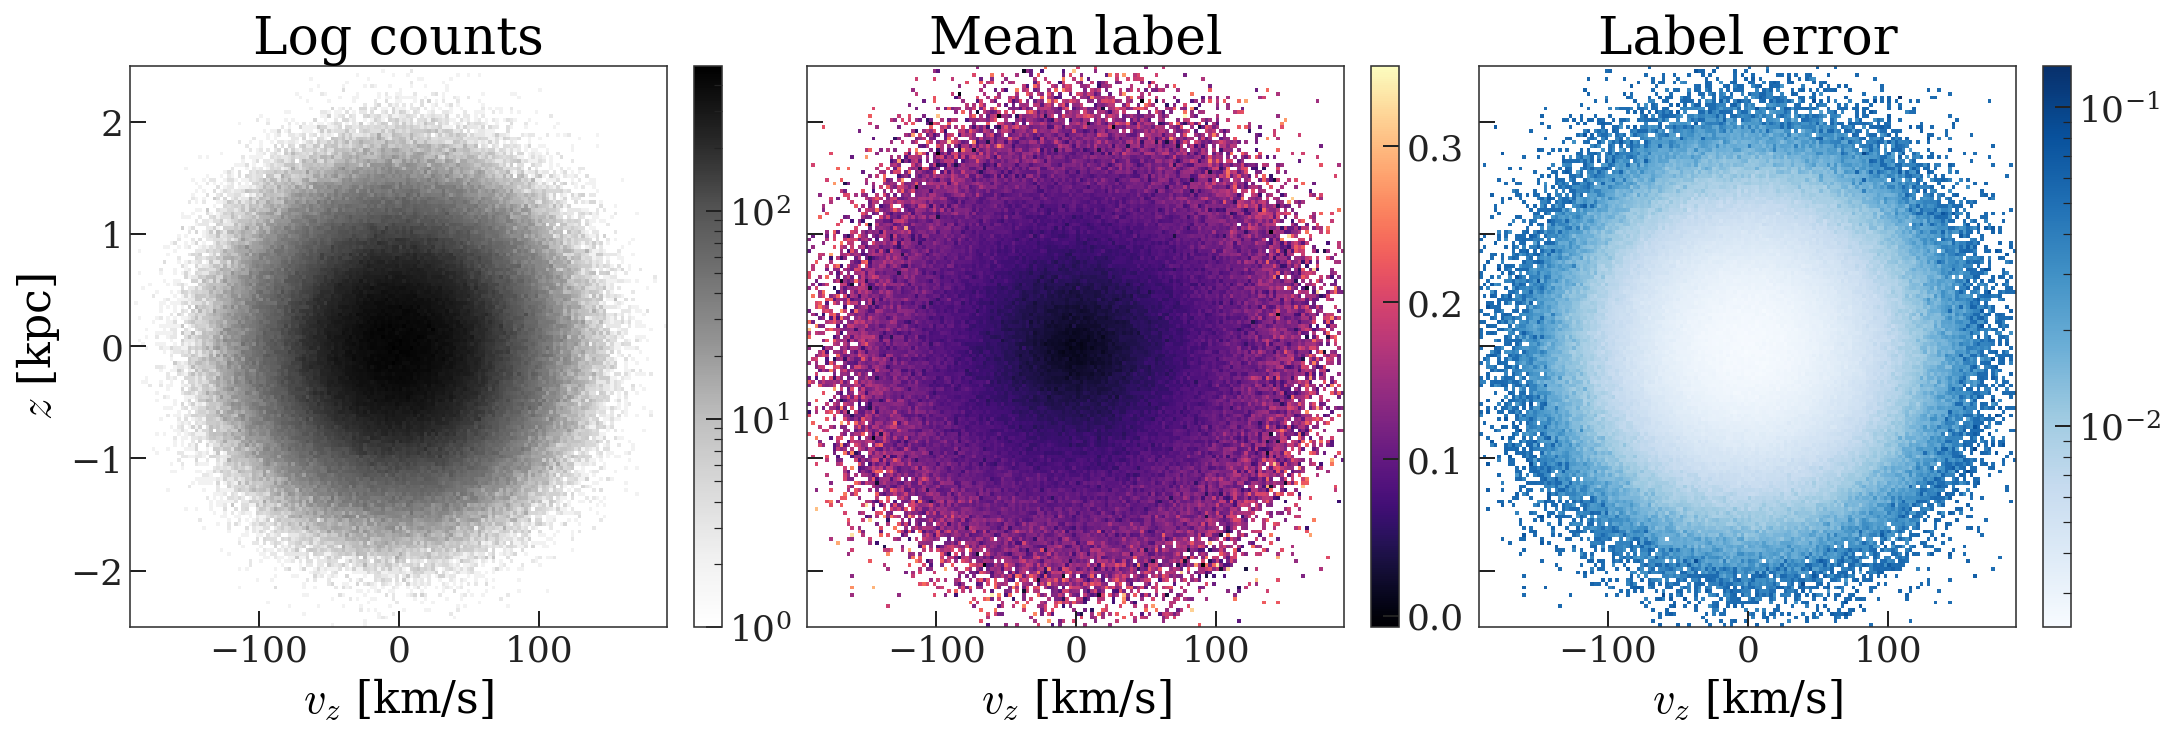

In [4]:
_ = plot_bdata(bdata)

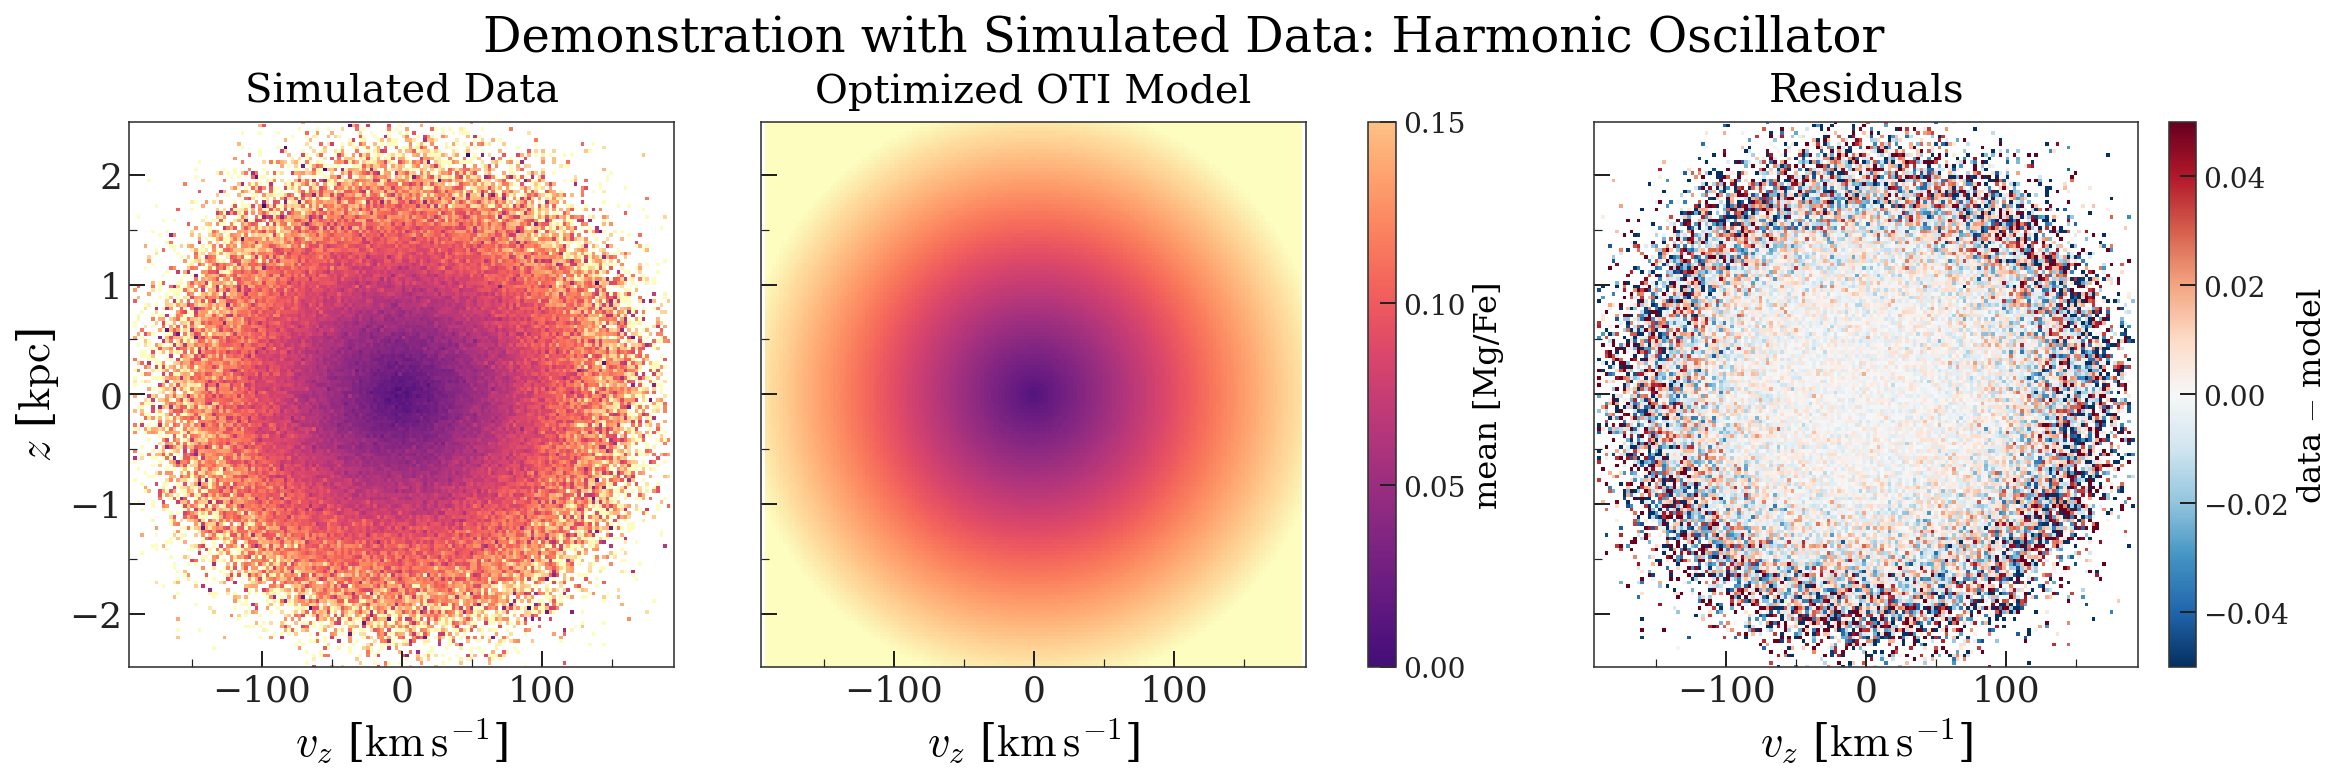

In [5]:
fig, axes = plot_data_model_residual(
    model, bdata, res_params, zlim=max_z, suptitle2="Harmonic Oscillator"
)
fig.savefig("../tex/figures/sho-data-model.pdf", dpi=250)

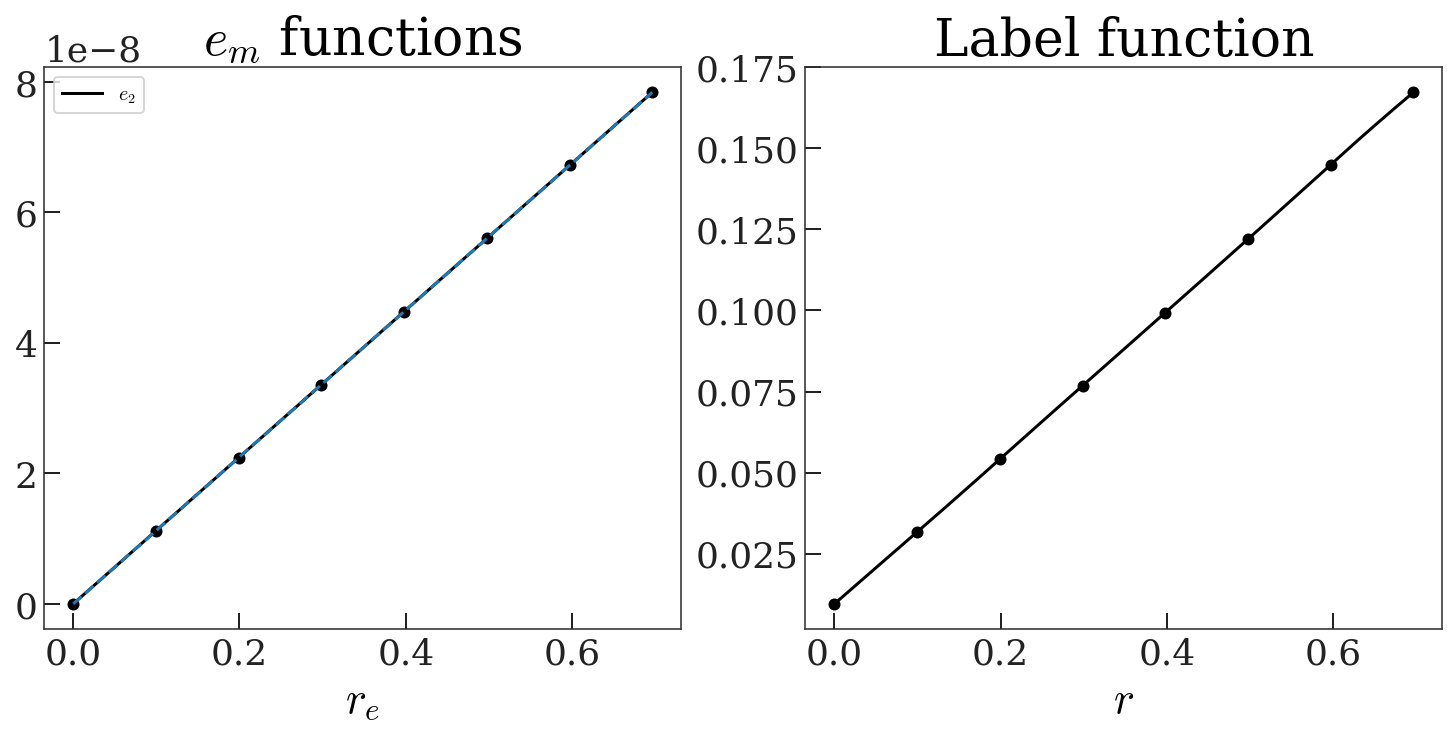

In [6]:
_ = plot_spline_functions(model, res_params)

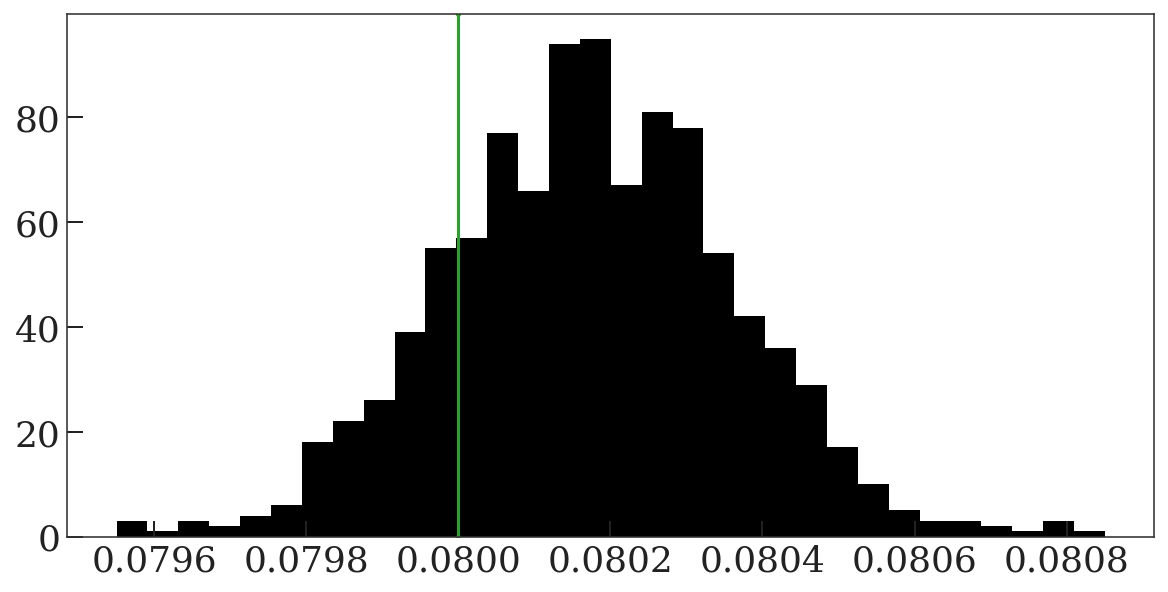

In [7]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
ax.hist(np.exp(mcmc_states.position["ln_Omega0"]), bins=32)
ax.axvline(true_Omega, color="tab:green")

In [8]:
accs = []
grid = np.linspace(-1, 1, 512) * max_z
for p in mcmc_params:
    acc = model.get_acceleration(grid, p)
    accs.append(acc.value)
accs = accs * acc.unit

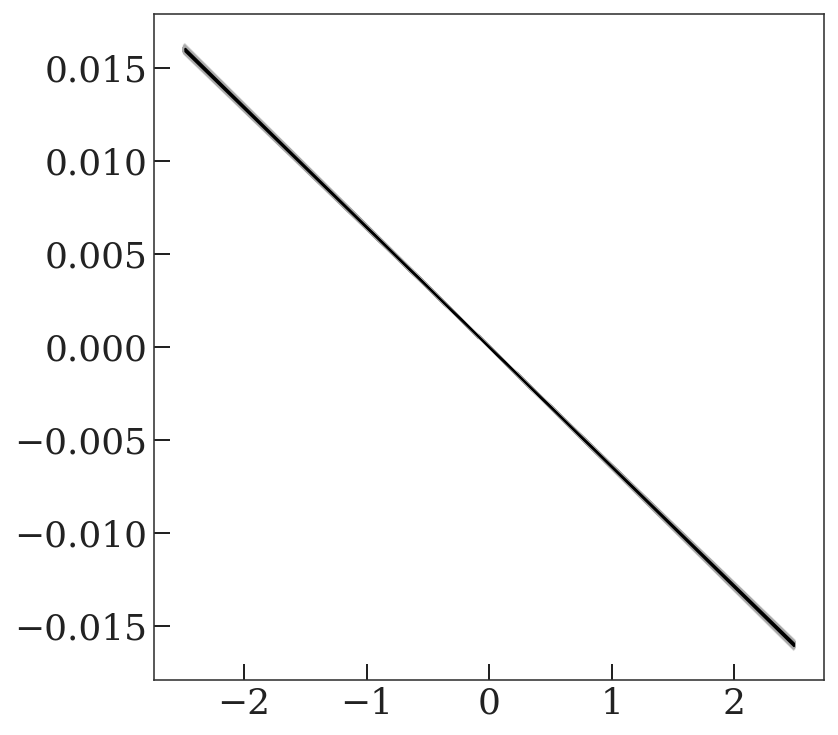

In [9]:
plt.plot(grid, accs.T, marker="", alpha=0.1, color="#aaaaaa")

p1, p2 = np.nanpercentile(accs.value, [16, 84], axis=0)
plt.fill_between(grid.value, p1, p2, color="k", zorder=10)

In [10]:
a_unit = u.km / u.s / u.Myr
true_acc = gala_pot.acceleration(grid.reshape(1, -1))[0].to(a_unit)
acc = accs.to(a_unit)
dacc = acc.T - true_acc[:, None]

In [11]:
bestfit_acc = model.get_acceleration(grid, res_params).to(a_unit)

In [12]:
subset_N = 20_000
aaf = model.compute_action_angle(
    pdata["z"][:subset_N], pdata["vz"][:subset_N], res_params
)

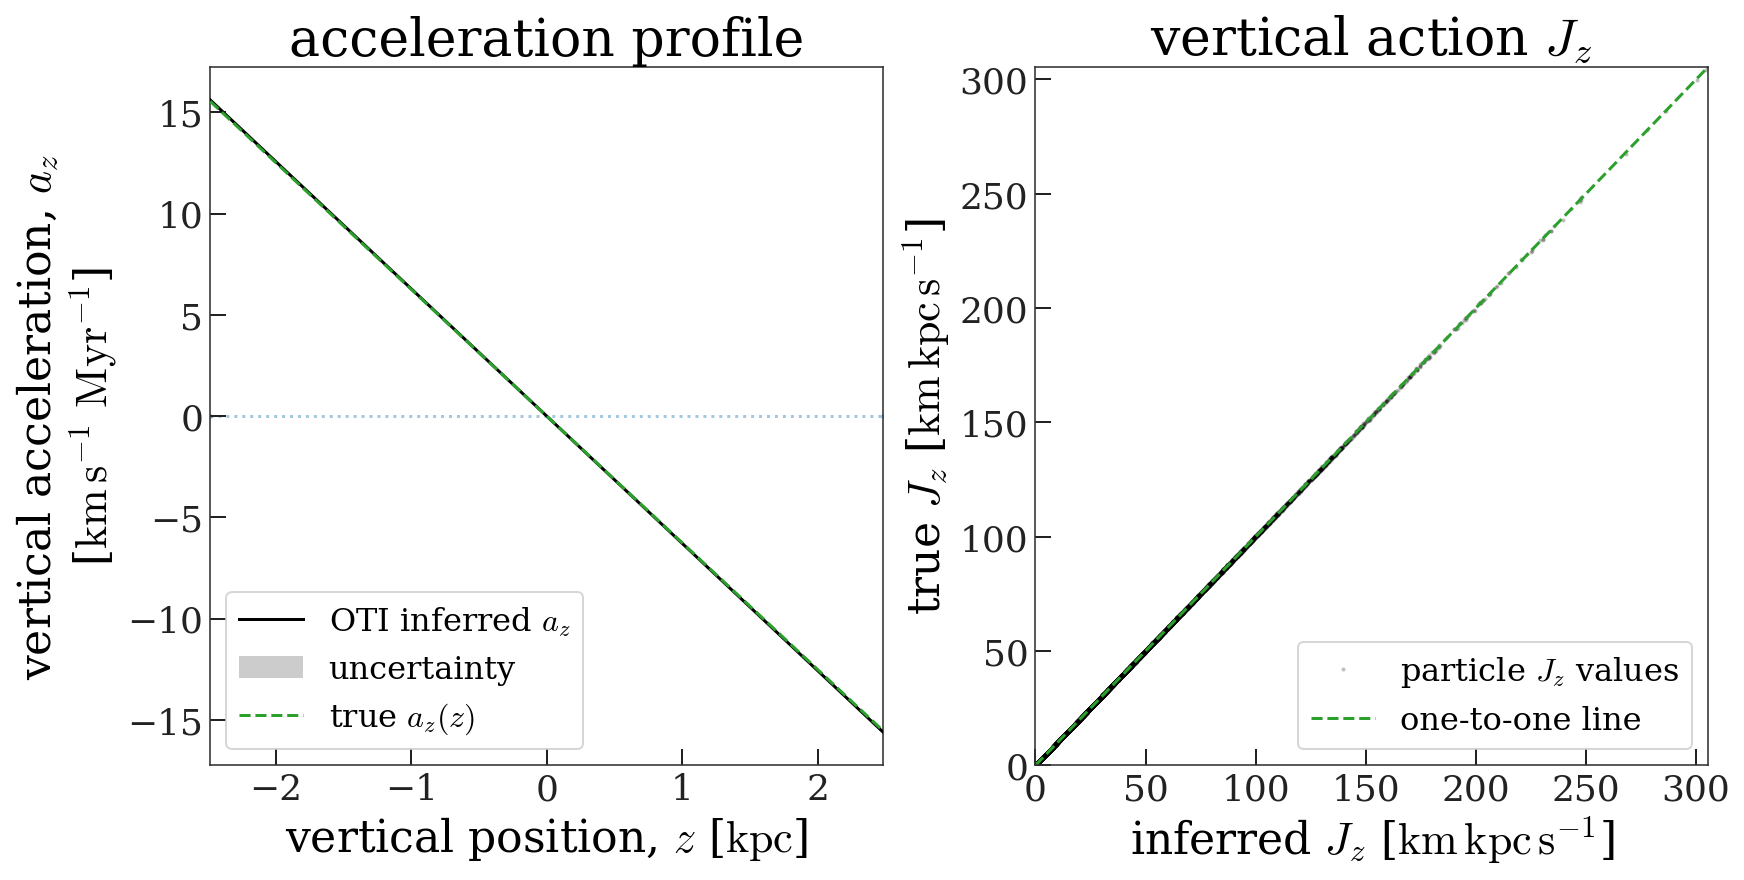

In [13]:
plot_az_Jz(np.mean(accs, axis=0), accs, grid, aaf, true_acc, pdata["Jz"][:subset_N]);

In [14]:
zlim = np.array([-1, 1]) * max_z.value
vzlim = np.array([-1, 1]) * max_vz.to_value(u.km / u.s)

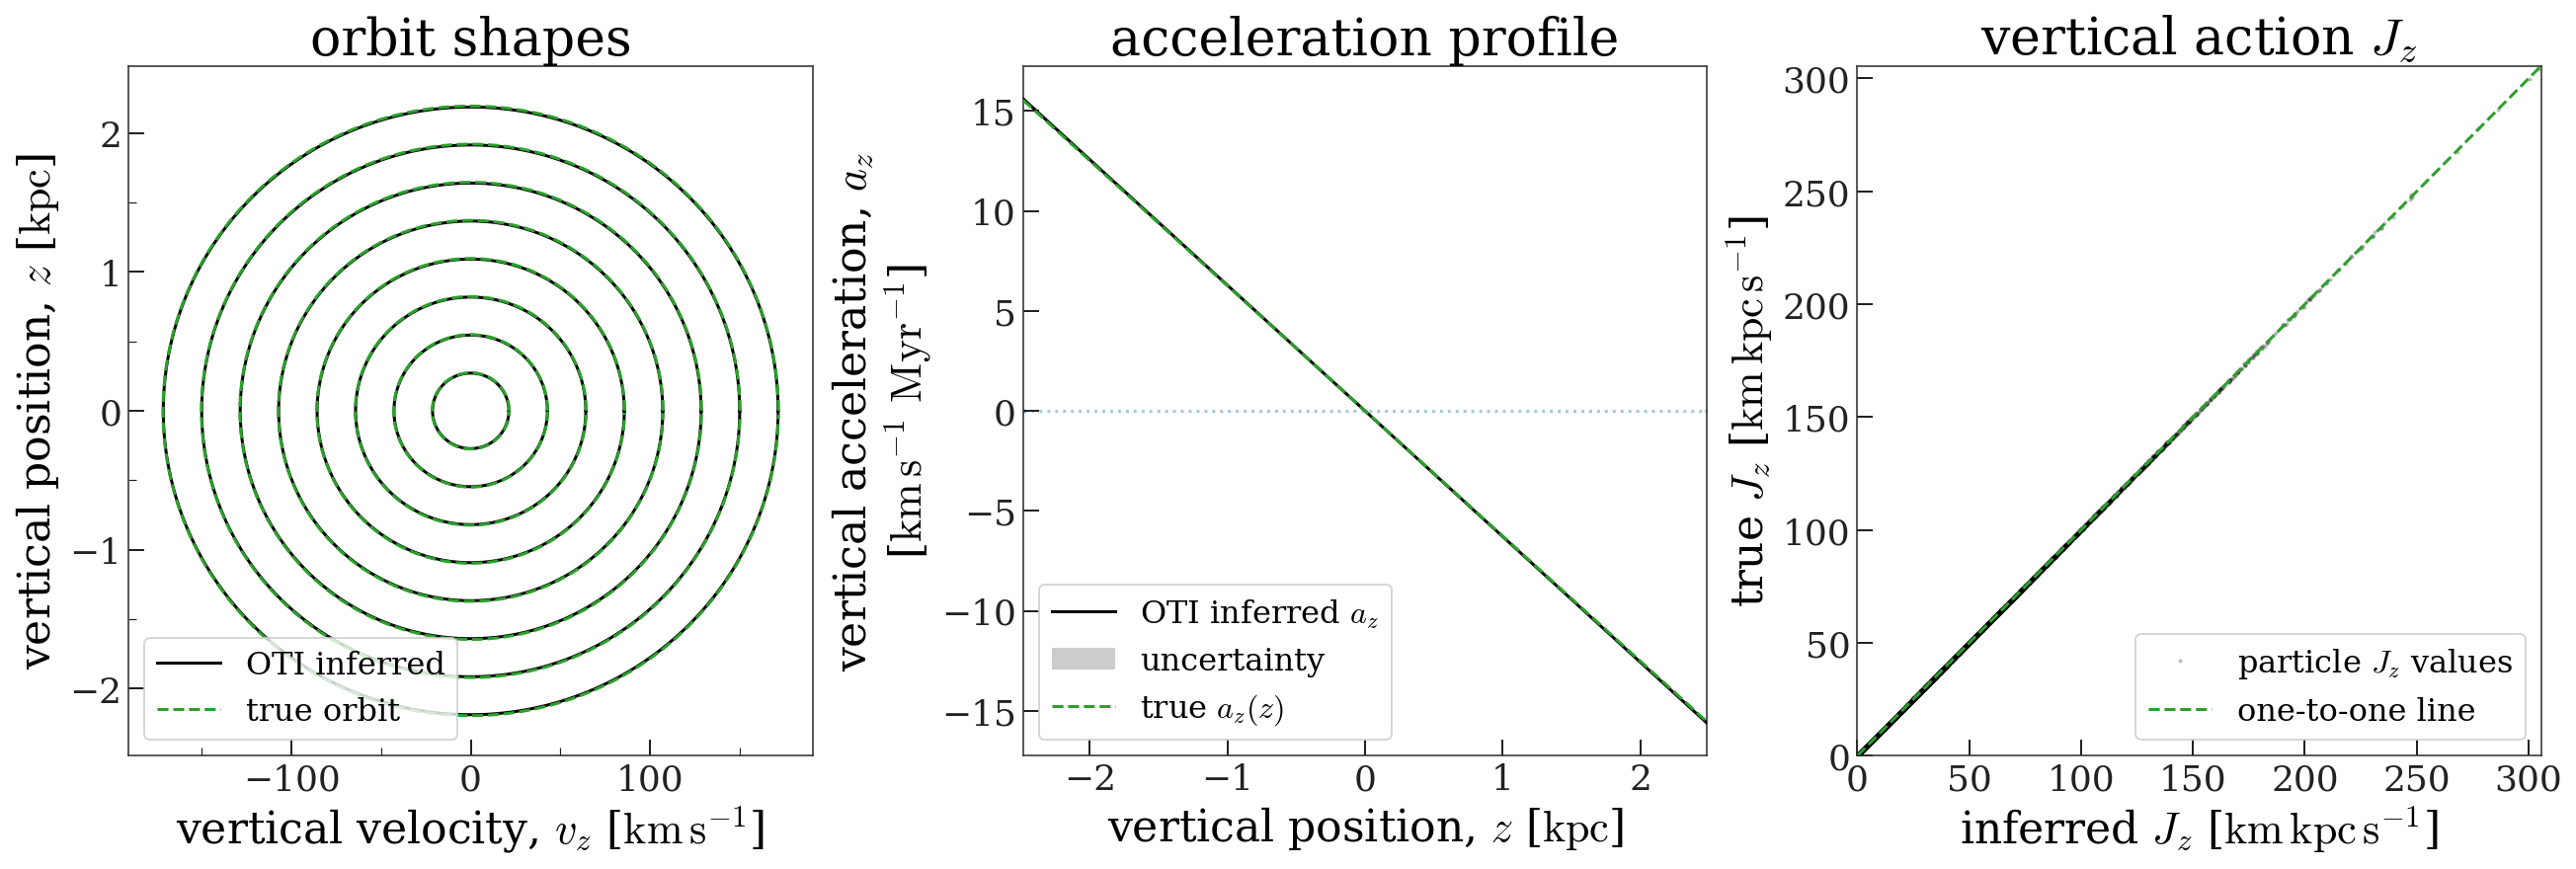

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6.0), layout="constrained")

ax = axes[0]

orbit_vzs = np.linspace(0, 1.0, 8 + 1)[1:] * max_vz * 0.9

T = 2 * np.pi / true_Omega
N_steps = 512
dt = T / N_steps

true_zvzs = np.zeros((len(orbit_vzs), 2, N_steps))
for i, vv in enumerate(orbit_vzs.decompose(galactic).value):
    orbit = gala_pot.integrate_orbit(
        [0.0, vv], dt=dt, t1=0, t2=T, Integrator=gi.DOPRI853Integrator
    )
    true_zvzs[i, 0] = orbit.x1.decompose(galactic).value
    true_zvzs[i, 1] = orbit.v_x1.decompose(galactic).value

plot_orbit_shapes(model, res_params, true_zvzs, zlim, vzlim, ax=ax)

plot_az_Jz(
    np.mean(accs, axis=0),
    accs,
    grid,
    aaf,
    true_acc,
    pdata["Jz"][:subset_N],
    axes=axes[1:],
)

fig.savefig("../tex/figures/sho-validation.pdf", dpi=250)

In [16]:
idx = np.abs(grid - 2 * u.kpc).argmin()
frac_dacc = dacc / true_acc[:, None]
np.diff(np.nanpercentile(frac_dacc[idx], [16, 84])) / 2

<Quantity [0.00465047]>

In [17]:
frac_diff = (
    ((aaf["J"] - pdata["Jz"][:subset_N]) / pdata["Jz"][:subset_N]).decompose().value
)
np.median(frac_diff), np.std(frac_diff)

(0.0008670416727039037, 0.01217373789848098)